## Visualize dPb initial conditions

In [1]:
import numpy as np
import matplotlib
import xarray as xr
import pickle
import cmocean
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# colors:
land_color         = '#a9a7a2'
land_outline_color = '#373736'

#### Files

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# Initial conditions (created with notebook forcing/create-TS-based-IC.ipynb)
IC_file = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-20220831/Pb-ini-20220911.nc')
dPb_IC  = IC_file['dPb'].values[0,:,:,:]

#### Functions

In [5]:
def plot_layer(layer, axis):
    # layer --- depth level to plot
    
    # Map:
    proj = Basemap(projection='eqdc',lat_0 = 75, lon_0 = -81, resolution='i', width=5.4e6, height=3.6e6, ax=axis)
    proj.drawcoastlines(color=land_outline_color, linewidth=0.6);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=2);
    
    # Plot initial conditions and land mask:
    x, y    = proj(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    plot_IC = np.ma.masked_where(mesh_bathy[layer,:,:] < 0.1, dPb_IC[layer,:,:])
    CB1     = proj.pcolormesh(x, y, plot_IC[imin:imax,jmin:jmax]*1e12, cmap=cmocean.cm.thermal, vmin=0, vmax=30) 
    proj.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=ListedColormap([land_color]), vmin=0, vmax=1)
    
    return CB1

#### Figure

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


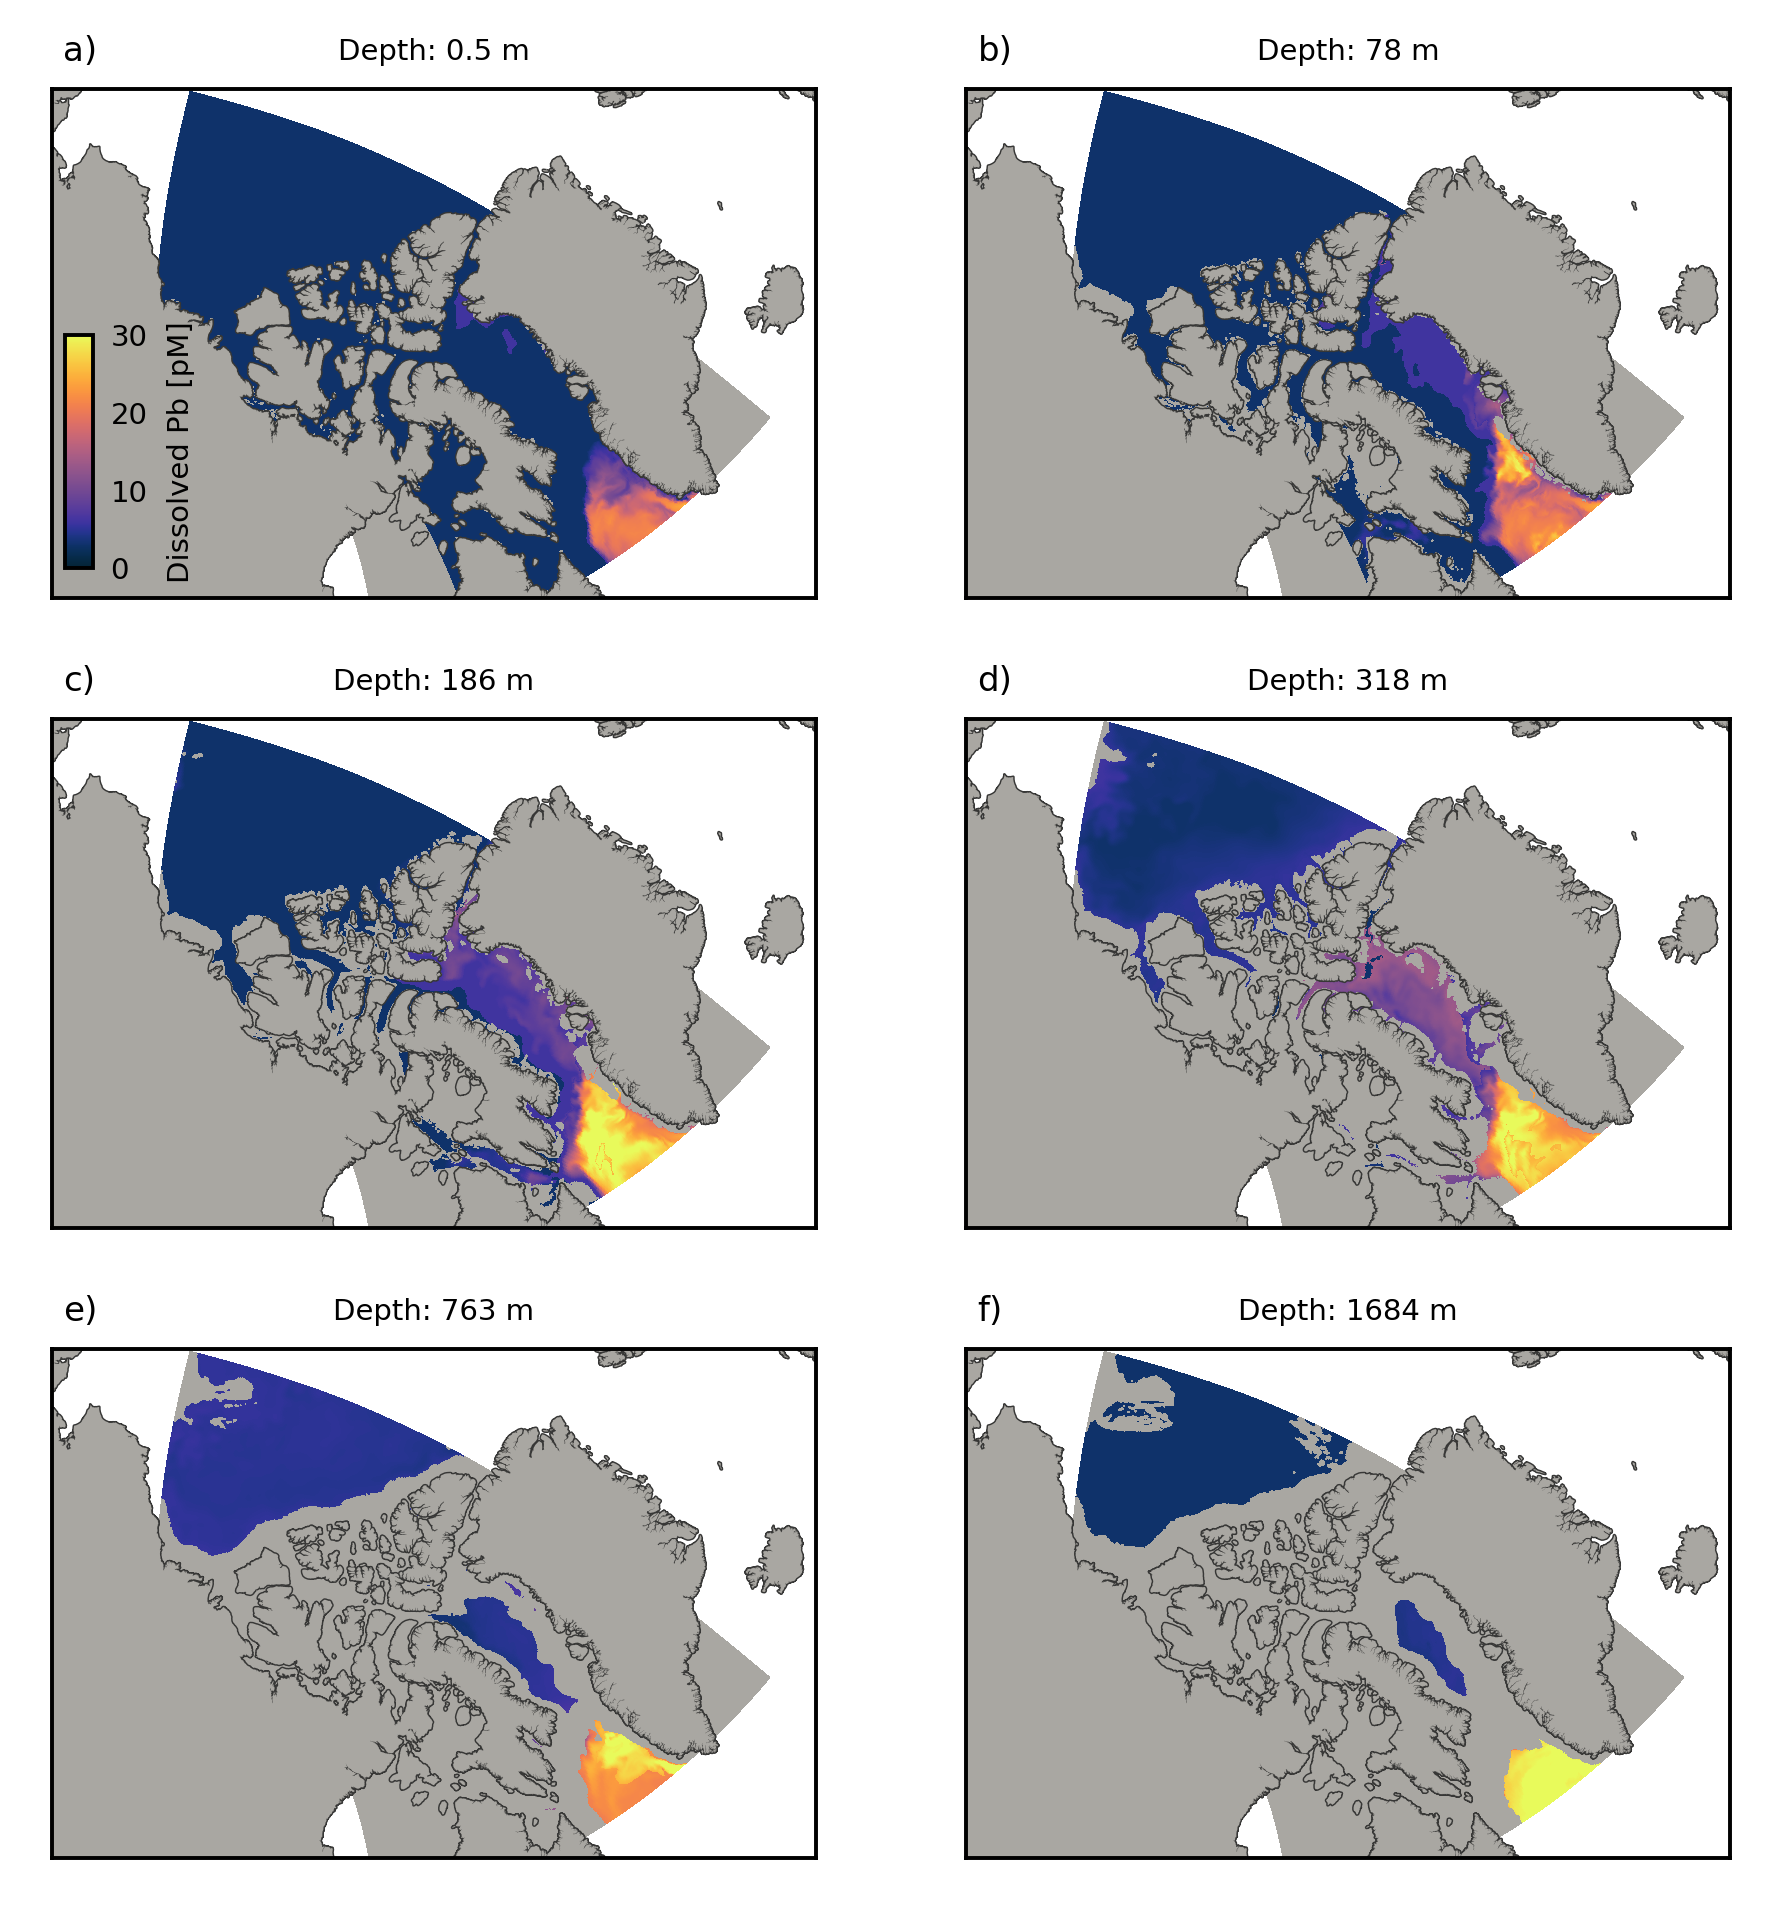

In [11]:
fig, ax = plt.subplots(3,2, figsize=(4.5*1.2,3.7*1.5), dpi=350)

labels       = ['a)','b)','c)','d)','e)','f)']
depth_levels = [0, 20, 25, 28, 33, 38]

for n, axis in enumerate(ax.ravel()):
    CB = plot_layer(depth_levels[n], axis)
    
    if n==0: # Color bar
        cbaxes1 = fig.add_axes([0.065, 0.70, 0.015, 0.12]);
        CBar1   = plt.colorbar(CB, ax=axis, cax=cbaxes1, ticks=[0,10,20,30]); 
        CBar1.set_label('Dissolved Pb [pM]', fontsize=6)
        CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
    
    axis.text(0.8e5, 3.8e6, f'{labels[n]}', fontsize=7);
    
    if (depths[depth_levels[n]] >=10):
        axis.set_title(f'Depth: {depths[depth_levels[n]]:.0f} m', fontsize=6)
    else:
        axis.set_title(f'Depth: {depths[depth_levels[n]]:.1f} m', fontsize=6)

plt.tight_layout()

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/S1-initial-conditions.jpg', dpi=350, bbox_inches='tight')